# Working with AMBench data in SciServer

## Find, retrieve, and process image data for materials science

#### Version 4

#### CB: An overview of the notebook would be helpful.  Something like: this notebook executes a query to the AMBench metadata repository via its API, then retrieves and processes the records.  It then performs some basic image analysis and plots the results.

# Setup: prepare the notebook

## Install and import required packages

First, we need to import packages that we will use to do the processing. Each import statement includes a comment describing what that package does.

#### CB: The pycdcs package is used in this notebook to query the AMBench metadata repository that contains information about the AMBench 2018 data.

In [1]:
# !pip install git+https://github.com/lmhale99/pycdcs
# print('ok')

#### CB: I'm not sure we need the inline import comments.  It's probably sufficient to just have the "Data processing packages" and similar comments just before the import statements.  I expect that most of the people using this notebook will be familiar with most of those libraries or will go look them up.

In [10]:
# Data processing packages
import pandas
import math
import numpy as np

# Package to find images in the AMBench repository
## This will allow us to find images to process
## These packages query NIST's Configurable Data Curation System (CDCS):
### https://www.nist.gov/itl/ssd/information-systems-group/configurable-data-curation-system-cdcs
from cdcs import CDCS

# Package to parse metadata from the AMBench repository to find where to download image files
import lxml.etree as et

# Packages to download and save image files
import requests
from urllib import request
import os

# Packages to do image processing once we have the images downloaded
## From the scikit-image package; we only import the parts of the package that we need 
### scikit-image website: https://scikit-image.org/
from skimage import io              # read/write images
from skimage import filters         # apply filters to images
from skimage import segmentation    # divide image into sections
from skimage import morphology    # work with features found in image
from skimage import measure         # measure pixel sizes of features within image

### Packages to plot results
import matplotlib.pyplot as plt   
import matplotlib.image as mpimg  
import matplotlib.patches as patches

pandas.set_option('display.max_colwidth', None)

print('Packages imported!')

Packages imported!


## Create functions

For some complex operations that we need to do repeatedly, it's easier to move the operations into a function call. This slows down the code slightly, but makes it much easier to read and to follow the logic of the notebook. 

#### CB: The first two are helper functions to process the XML records that are returned by the AMBench metadata repository.  If possible, I'd move these to a separate library that gets imported along with pycdcs.

In [3]:
# Function to get download links from XML returned by AMBench data repository
# function xml_url_find(xml,searchphrase,mtype):
## Inputs:
### xml: contents of XML file for one of the ambench.nist.gov datasets, in string format
### searchphrase: search phrase contained in the file name (in our case, we search for "BF")
### mtype: filetype (in our case, "image/tiff")

## Returns:
### A four-item list containing:
#### (0) the name of the image file to be downloaded
#### (1) the URL at which to download the image file
#### (2) laser track number for that image
#### (3) case label for that image

def xml_url_find(xml,searchphrase,mtype):
    root=et.fromstring(xml)
    caseid=root.find('.//TraceID')[0].tag[5]
    track=root.find('.//TrackNumber')
    for element in root.iter('downloadURL'):
        u=request.urlopen(element.text)
        if (    # search through XML to find searchphrase in filename and mytpe in file type
            (searchphrase in u.info().get_filename()) 
            and (mtype in u.info().get_content_type())
        ):
            name=u.info().get_filename()
            url=element.text
            return [name,url,track.text,caseid]

###### JR: since we are getting and processing images one by one, we no longer need this, keeping for reference
# #Given an xml string like the one returned by CDCS_xml, will return a dataframe of download links for the files on the AMBench
# #page (includes name, description, comments, etc.)
# def CDCS_downloads(xml):
#     root=et.fromstring(xml)
#     result=[]
#     for element in root.iter('downloadURL'):
#         entry={}
#         for e in element.getparent():
#             entry[e.tag]=e.text
#         result.append(entry)
#     df=py.DataFrame.from_dict(result,orient='columns')
#     return df        


# #### draw_box_opt
######## JR: we are now doing these steps in the main body, keeping this function commented out for reference
# # This method (1) crops the melt pool images (to reduce runtime), (2) applies the felzenszwalb segmentation algorithm to the image, (3) removes smaller regions (eliminate some background noise), (4) acquires a table of center coordinates for the remaining regions, (5) measures the distances from centers to the center of the image, (6) finds the index number of the closest region, (7) returns information about the closes region

# # Parameters:
# # - image to be analyzed

# # Returns:
# # - list of RegionProperties related to the melt pool region
# def draw_box_opt(image):
#     cropim=image[900:1800,800:3400] #cropping so that there's less pixels to cover - incredibly slow if left at original size
#     segments=segmentation.felzenszwalb(cropim,scale=270,sigma=0.8,min_size=1000)
#     isolateim=morphology.remove_small_objects(segments,100000)
#     center=measure.regionprops_table(isolateim,properties=['centroid']) #table of information about the center points of regions
#     distances=[]
#     for n in range(len(center['centroid-0'])):
#         distances.append(math.dist([center['centroid-0'][n],center['centroid-1'][n]],[450,1300]))
#     index=distances.index(min(distances)) #Looking for the region closest to the center of the image - should be the melt pool
#     object_features=measure.regionprops(isolateim)
#     return object_features[index] 

print('ok')

ok


# 1. Find datasets to work with

The AMBench data repository includes hundreds (thousands?) of datasets associated with challenges. Each dataset includes metadata describing its purpose and various conditions (inputs?) used to generate it. The actual data consists of images (stored as .tiff files) stored on a separate server at NIST. The datasets retreived from the data repository contain pointers to the image locations.

This section of the notebook searches the AMBench data repository for a keyword - in this case, "MP" (for "melt pool"). It then downloads the metadata for all public datasets with your selected keyword. You can see information about each returned dataset by running the code block with the `describe_datasets = True`.

#### CB: Also, it would help to shorten the lines so horizontal scrolling is minimized, possibly adding a few more comments to explain these lines of code

In [4]:
keyword='MP'                # keyword to search data repository for: MP = melt pool
describe_datasets = True    # show name and basic metadata for each dataset
##show_dataset_xml = False     # parse xml to show full metadata for each dataset

print('querying AMBench data repository for keyword {0:}...'.format(keyword))
curator = CDCS('https://ambench.nist.gov/', username='') # query repository (CDCS) anonymously
datasets_df = curator.query(  # search for results, return as a pandas dataframe:
    keyword=keyword,           ## results should match this keyword
    template='AM-Bench-2018'   ## and be associated with this tempalte
    ) 

### convert all date fields to pandas date format:
for thiscol in ['creation_date', 'last_modification_date', 'last_change_date']:
    datasets_df.loc[:, thiscol] = pandas.to_datetime(datasets_df[thiscol], errors='coerce')
    
### use the dataset ID as the index of the dataframe, then sort by that ID    
datasets_df = datasets_df.set_index('id')

print('Found {0:,.0f} datasets matching keyword {1:}!'.format(len(datasets_df), keyword))
print('------------------------------------------------')

if (describe_datasets):
    for ix, thisrow in datasets_df.iterrows():
        print('\n')
        print('Dataset id = {0:}'.format(ix))
        print('\tTitle: {0:}'.format(thisrow['title']))
        print('\tCreated: {0:}'.format(thisrow['creation_date'].strftime('%Y-%m-%d')))
#         if (show_dataset_xml):
#             show_xml(thisrow['xml_content'])
        
print('------------------------------------------------')

querying AMBench data repository for keyword MP...
Found 10 datasets matching keyword MP!
------------------------------------------------


Dataset id = 61e2e74036f033d46e0672b4
	Title: AMB2018-02-AMMT-625-TR6-MP.xml
	Created: 2021-09-02


Dataset id = 61e2e71747ed0ce2c83c23ac
	Title: AMB2018-02-AMMT-625-TR5-MP.xml
	Created: 2021-09-02


Dataset id = 61e2e700f51a62700be8516a
	Title: AMB2018-02-AMMT-625-TR8-MP.xml
	Created: 2021-09-02


Dataset id = 61e2e6a3e0ade599482c5b77
	Title: AMB2018-02-AMMT-625-TR2-MP.xml
	Created: 2021-09-02


Dataset id = 61e2e653b8edd76d53d3d54f
	Title: AMB2018-02-AMMT-625-TR3-MP.xml
	Created: 2021-09-02


Dataset id = 61e2e63bf51a62700be850ec
	Title: AMB2018-02-AMMT-625-TR10-MP.xml
	Created: 2021-09-02


Dataset id = 61e2e580d682ae6fb2db87af
	Title: AMB2018-02-AMMT-625-TR4-MP.xml
	Created: 2021-09-02


Dataset id = 61e2e52fe0ade599482c58ba
	Title: AMB2018-02-AMMT-625-TR9-MP.xml
	Created: 2021-09-02


Dataset id = 61e2e4c4b8edd76d53d3cb8e
	Title: AMB2018-02-A

# 2. Find download links for each dataset

Most of the metadata returned by the AMBench data repository is stored in XML format, easy for computers to store and process but hard for humans to read. One important piece of metadata in each dataset is a field called `downloadURL`, which gives the location where image(s) associated with that dataset can be downloaded.

This notebook includes a helper function called `xml_url_find` that searches through the XML to find the download URL for each image to be processed. For this demo notebook, consider that function as a black box; if you want to learn how it works, see the function documentation in the setup step above. The `xml_url_find` function returns track, case, and image URL for each row in the dataset.

Each dataset includes several images (TIFF files), each associated with a specific track and case number. The code cell below loops through each dataset returns these track and case numbers, as well as the URL where the associated image can be downloaded.

In [5]:
searchphrase='BF'  # used by the xml_url_find function, don't worry about what it means now

datasets_df = datasets_df.assign(   # assign blanks to values to be computed later
    filename = np.nan, url = np.nan, track = np.nan, case = np.nan
) 

print('Finding URLs for images...')
cnt = 0
for ix, thisrow in datasets_df.iterrows():
    if (np.mod(cnt,5) == 0):
        print('\tFinding URL {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(datasets_df)))
    datasets_df.loc[ix, ['filename', 'url', 'track', 'case']] = xml_url_find(thisrow['xml_content'],'BF','image/tiff') # giving xml_url_find each xml string and searching for
    cnt += 1

    
# set track to numeric, then sort by track
datasets_df.loc[:, 'track'] = pandas.to_numeric(datasets_df['track'], downcast='integer', errors='coerce')
datasets_df = datasets_df.sort_values(by='track') 

print('\n')
print('Found download links for {0:,.0f} images!'.format(len(datasets_df['url'].dropna())))

#datasets_df[['url']]

Finding URLs for images...
	Finding URL 1 of 10...
	Finding URL 6 of 10...


Found download links for 10 images!


# 3. Download and process images

This code cell loops through each dataset you found in the previous section and performs the following operations on each (all the image processing is done using the `scikit` image processing package):

1. Downloads the image from the URL you found in the last section
1. Selects a smaller region of the image to work with (to save processing time)
1. Segments that region using the Felzenszwalb algorithm
1. Removes smaller regions (eliminate some background noise)
1. Acquires a table of center coordinates for each remaining region
1. Measures the distances from centers to the center of the entire relevant section image
1. Finds the index number of the closest region
1. Returns information about the closest region
1. Uses those results to measure the width and depth of the melt pool
1. Optionally displays the image with the relevant section marked and measured values displayed

Set `show_image = True` to see each image.

Getting images...
	Getting image 1 of 10: track 1 case C...
showing marked image...
	Getting image 2 of 10: track 2 case C...
showing marked image...
	Getting image 3 of 10: track 3 case C...
showing marked image...
	Getting image 4 of 10: track 4 case C...
showing marked image...
	Getting image 5 of 10: track 5 case A...
showing marked image...
	Getting image 6 of 10: track 6 case A...
showing marked image...
	Getting image 7 of 10: track 7 case A...
showing marked image...
	Getting image 8 of 10: track 8 case B...
showing marked image...
	Getting image 9 of 10: track 9 case B...
showing marked image...
	Getting image 10 of 10: track 10 case B...
showing marked image...


,track,case,melt_pool_width_microns,melt_pool_depth_microns
id,,,,
61e2e4c4b8edd76d53d3cb8e,1,C,75.268,45.632
61e2e6a3e0ade599482c5b77,2,C,31.930,26.350
61e2e653b8edd76d53d3d54f,3,C,104.470,49.848
61e2e580d682ae6fb2db87af,4,C,114.204,44.764
61e2e71747ed0ce2c83c23ac,5,A,52.204,34.782
61e2e74036f033d46e0672b4,6,A,50.158,33.604
61e2e46326f0a0b0e709c1df,7,A,36.518,31.558
61e2e700f51a62700be8516a,8,B,61.132,39.370
61e2e52fe0ade599482c58ba,9,B,45.942,31.930


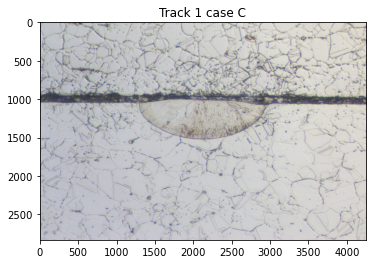

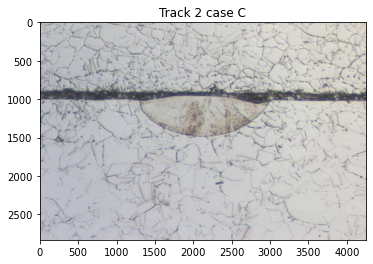

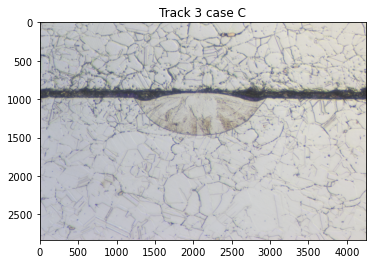

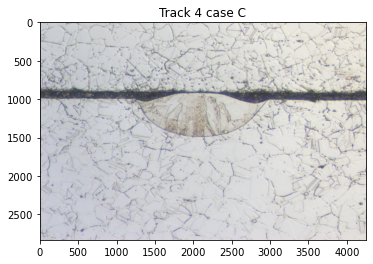

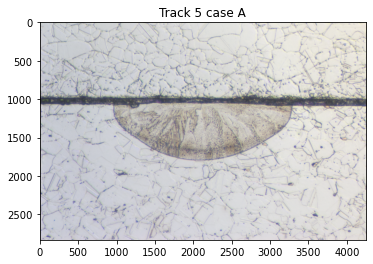

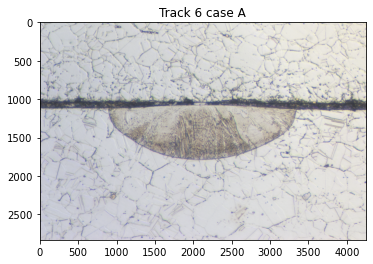

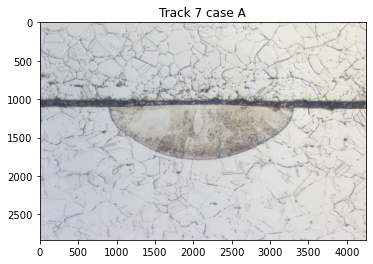

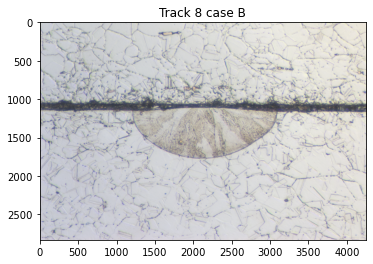

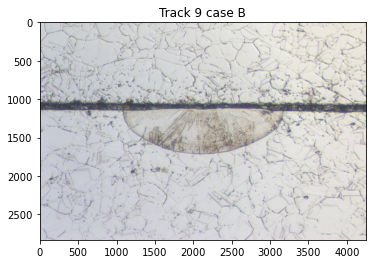

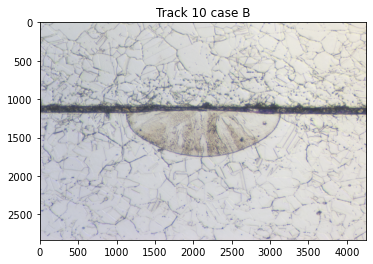

In [27]:
show_images = True   # set to True to see what the images look like as they are found

datasets_df = datasets_df.assign(     # assign blanks for values to compute later
    melt_pool_width_microns = np.nan, melt_pool_depth_microns = np.nan
) 

# To save processing time, the segmentation algorithm is applied to only part of the image
## The full image is 2832 pixels wide by 4248 pixels high
### By default, segmentation is done for 900 <= x < 1800; 800 <= y <= 3400, change that here
imagebox = {'xmin': 900, 'xmax': 1800, 'ymin': 800, 'ymax': 3400}


print('Getting images...')
cnt = 0
for ix, thisrow in datasets_df.iterrows():
    #if (np.mod(cnt,5) == 0):
    print('\tGetting image {0:,.0f} of {1:,.0f}: track {2:,.0f} case {3:}...'.format(
        cnt+1, len(datasets_df), thisrow['track'], thisrow['case'])
         )
    this_image = io.imread(thisrow['url'])
    
    cropim = this_image[  # Do analysis on a cropped image, coordinates determined by imagebox
        imagebox['xmin']:imagebox['xmax'],imagebox['ymin']:imagebox['ymax']
    ] 
    segments=segmentation.felzenszwalb( # use felezenszwalb algorithm to autosegment cropped area
        cropim,scale=270,sigma=0.8,min_size=1000
    )
    isolateim=morphology.remove_small_objects( # remove small objects, likely background noise
        segments, 100000
    )
    center=measure.regionprops_table( # returns table of info about the center points of regions
        isolateim,properties=['centroid']
    ) 
    
    distances=[]
    for n in range(len(center['centroid-0'])):   # for each region found by segmentation...
        distances.append(                        ## calculate distance to center of analysis area
            math.dist([center['centroid-0'][n],
                       center['centroid-1'][n]
                      ],[imagebox['xmax']-imagebox['xmin'],imagebox['ymax']-imagebox['ymin']]
                     )
        )
    
    # The region closest to the center of the analysis region should be the melt pool
    ## using the bbox drawn around that region, find the melt pool to find width and depth
    index=distances.index(min(distances))
    object_features=measure.regionprops(isolateim)    
    minr,minc,maxr,maxc = object_features[index].bbox 
    
    ### convert from pixel coordinates to physical measurements in microns
    datasets_df.loc[ix, 'melt_pool_width_microns'] = (maxc-minc)*(0.062)
    datasets_df.loc[ix, 'melt_pool_depth_microns'] = (maxr-minr)*(0.062)

    if (show_images):
        # show image
        print('showing marked image...')
        fig, ax = plt.subplots(1,1)
        ax.imshow(this_image)
        ax.set_title('Track {0:.0f} case {1:}'.format(thisrow['track'], thisrow['case']))
#         rect1 = patches.Rectangle((imagebox['xmin'], imagebox['ymin']), imagebox['ymax']-imagebox['ymin'], imagebox['xmax']-imagebox['xmin'], linewidth=1, edgecolor='b', facecolor='none')
#         print(minr,minc,maxr,maxc)        
#         rect2 = patches.Rectangle((imagebox['xmin']+minr, imagebox['ymax']-minc), maxc-minc, maxr-minr, linewidth=1, edgecolor='r', facecolor='none')
#         ax.add_patch(rect1)
#         ax.add_patch(rect2)
        
    cnt += 1


datasets_df.loc[:, 'track'] = pandas.to_numeric(datasets_df['track'], downcast='integer', errors='coerce')
datasets_df = datasets_df[['title', 'track', 'case', 'melt_pool_width_microns', 'melt_pool_depth_microns', 'template', 'workspace',  'creation_date', 'last_modification_date', 'last_change_date', 'filename', 'url', 'xml_content', 'template_title', 'user_id']]
datasets_df = datasets_df.sort_values(by='track')

#print(datasets_df.dtypes)
datasets_df[['track', 'case', 'melt_pool_width_microns', 'melt_pool_depth_microns']]
#print('ok')


## 4. Make plots of melt pool sizes

Bar plot of melt pool widths

<AxesSubplot:xlabel='track'>

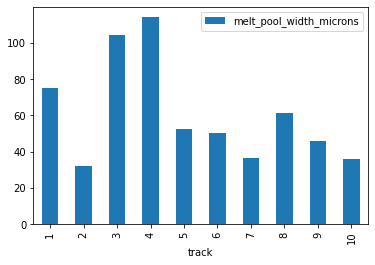

In [28]:
datasets_df[['melt_pool_width_microns', 'track']].plot(y='melt_pool_width_microns',x='track',kind='bar')

Bar plot of melt pool depths

<AxesSubplot:xlabel='track'>

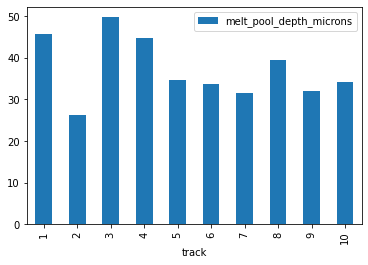

In [29]:
datasets_df[['melt_pool_depth_microns', 'track']].plot(y='melt_pool_depth_microns',x='track',kind='bar')

<AxesSubplot:xlabel='melt_pool_depth_microns', ylabel='melt_pool_depth_microns'>

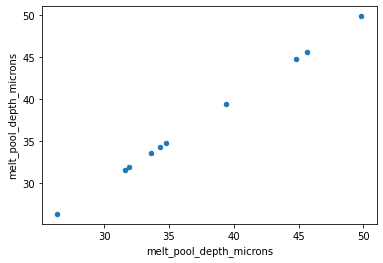

In [30]:
datasets_df.plot('melt_pool_depth_microns', 'melt_pool_depth_microns', kind='scatter')

Example of what the image looks like with the bbox marked

In [ ]:
# fig, ax = plt.subplots()
# minr,minc,maxr,maxc=bboxes[4]
# ax.imshow(result[4][900:1800,800:3400])
# bx = (minc, maxc, maxc, minc, minc)
# by = (minr, minr, maxr, maxr, minr)
# ax.plot(bx, by, '-b', linewidth=2.5)
# plt.show()

In [ ]:


# depths=[]
# widths=[]
# bboxes=[]
# for im in dfres['image']:
#     objf=draw_box_opt(im)
#     bboxes.append(objf.bbox)
#     minr,minc,maxr,maxc=objf.bbox #using the bbox drawn around the melt pool to find width and depth
#     widths.append((maxc-minc)*(0.062)) #using the conversion given in the CDCS comment above the images to convert to mm (1 pixel=0.062 microns)
#     depths.append((maxr-minr)*(0.062))
# dat={'width':widths,'depth':depths,'track':trace,'case':case}
# dfmp=pandas.DataFrame(dat)
# dfmp

In [ ]:

# fig = plt.subplots(1,1)

# for ix, thisrow in datasets_df.iterrows():
    
#     print('Getting image for track {0:,.0f} case {1:}...'.format(thisrow['track'], thisrow['case']))
#     this_image = io.imread(thisrow['url'])

#     print('\tmeasuring melt pool in image...')
#     minr,minc,maxr,maxc = draw_box_opt(this_image).bbox #using the bbox drawn around the melt pool to find width and depth

#     datasets_df.loc[ix, 'melt_pool_width_microns'] = (maxc-minc)*(0.062)
#     datasets_df.loc[ix, 'melt_pool_depth_microns'] = (maxr-minr)*(0.062)
    
#     print('\tshowing marked image...')    
#     fig, ax = plt.subplots(1,1)
    
#     bx = (minc, maxc, maxc, minc, minc)
#     by = (minr, minr, maxr, maxr, minr)
    
#     ax.imshow(this_image[900:1800,800:3400])
#     ax.plot(bx, by, '-b', linewidth=2.5)
#     ax.set_title('Track {0:.0f} case {1:} (width = {2:.1f} µm, depth = {3:.1f} µm)'.format(thisrow['track'], thisrow['case'], datasets_df.loc[ix]['melt_pool_width_microns'], datasets_df.loc[ix]['melt_pool_depth_microns']))
#     plt.show()
    
    
#     #using the conversion given in the CDCS comment above the images to convert to mm (1 pixel=0.062 microns)
# # objf
# #datasets_df.head(2)
# #plt.show()
# print('Done')

In [ ]:
def show_xml(xml):
    print('xml tree:')
    print('---------')
    root = et.fromstring(xml)
    for i in range(0, len(root)):
        if (len(root[i]) <= 1):
            print('{0:.0f}. {1:}: {2:}'.format(i, root[i].tag, root[i].text))
        else:
            print('{0:.0f}. {1:} has {2:.0f} elements!'.format(i, root[i].tag, len(root[i])))
            for j in range(0, len(root[i])):
                if (len(root[i][j]) <= 1):
                    print('\t{0:.0f}.{1:.0f}. {2:}: {3:}'.format(i, j, root[i][j].tag, root[i][j].text))
                else:
                    print('\t{0:.0f}.{1:.0f}. {2:} has {3:.0f} elements!'.format(i, j, root[i][j].tag, len(root[i][j])))
                    for k in range(0, len(root[i][j])):
                        if (len(root[i][j][k]) <= 1):
                            print('\t\t{0:.0f}.{1:.0f}.{2:.0f}. {3:}: {4:}'.format(i, j, k, root[i][j][k].tag, root[i][j][k].text))
                        else:
                            print('\t\t\t{0:.0f}.{1:.0f}.{2:.0f}. {3:} has {4:.0f} elements!'.format(i, j, k, root[i][j][k].tag, len(root[i][j][k])))
                            for l in range(0, len(root[i][j][k])):
                                if (len(root[i][j][k][l]) <= 1):
                                    print('\t\t\t{0:.0f}.{1:.0f}.{2:.0f}.{3:.0f}. {4:}: {5:}'.format(i, j, k, l, root[i][j][k][l].tag, root[i][j][k][l].text))
                                else:
                                    for m in range(0, len(root[i][j][k][l])):
                                        if (len(root[i][j][k][l][m]) <= 1):
                                            print('\t\t\t\t{0:.0f}.{1:.0f}.{2:.0f}.{3:.0f}.{4:.0f}. {5:}: {6:}'.format(i, j, k, l, m, root[i][j][k][l][m].tag, root[i][j][k][l][m].text))
                                        else:
                                            print('\t\t\t\t{0:.0f}.{1:.0f}.{2:.0f}.{3:.0f}.{4:.0f}. {5:} has {6:.0f} elements!'.format(i, j, k, l, m, root[i][j][k][l][m].tag, len(root[i][j][k][l][m])))